# Fire Detection Classifier using pre-trained ResNet50 model

For this porpose, this transfer learning approach explores **feature extracting** and **Fine-tuning** technics

# Install and Import Dependencies

In [ ]:
# install wandb
!pip install wandb -qU

In [ ]:
!pip install codecarbon

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from codecarbon import EmissionsTracker

In [ ]:
wandb.login()

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

# Fetch and Data Segregation

## Fetch Data

In [ ]:
args = {
    "project_name": "fire_detection_classifier",
    "artifact_name": "images_raw_data:latest"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact images_raw_data:latest, 95.52MB. 10002 files... 
wandb:   10002 of 10002 files downloaded.  
Done. 0:1:13.8
30-11-2022 02:43:52 Path: ./artifacts/images_raw_data:v0


In [ ]:
run.finish()

Check the data directory

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 10002 files belonging to 2 classes.


In [ ]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
raw_wb

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

## Data Segregation

In [ ]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [ ]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 313
Number of train batches: 251
Number of validation batches: 50
Number of test batches: 12


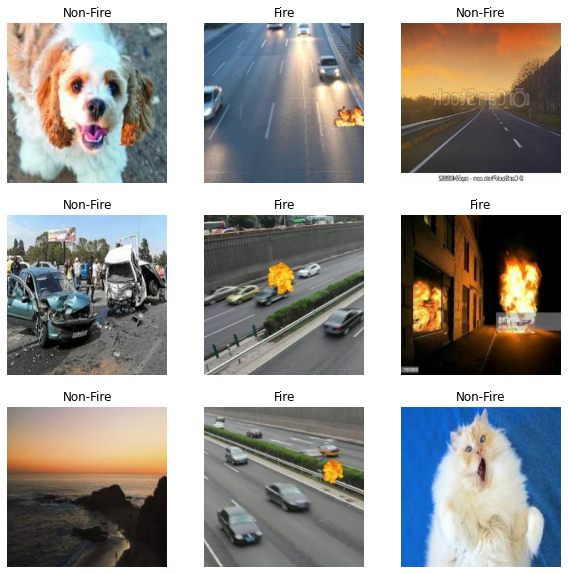

In [ ]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

# Configure the dataset for performance


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Using some data augmentation 

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

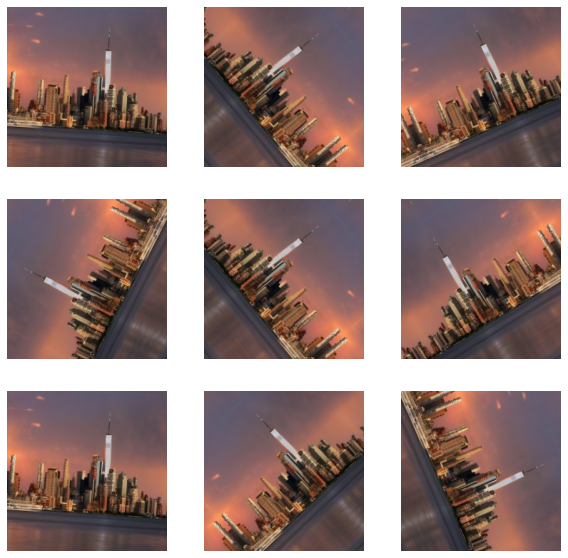

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Creating the pre-trained model using ResNet50

## Iniciating WandB project

In [ ]:
args = {
  "project_name": "fire_detection_classifier"
}

In [ ]:
run = wandb.init(entity="euripedes", project=args["project_name"], job_type="Train")

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
model_resNet50 = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model_resNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_resNet50(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


## Feature Extraction

In [ ]:
model_resNet50.trainable = False

In [ ]:
model_resNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = model_resNet50(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model_resNet50 = tf.keras.Model(inputs, outputs)

# Compile the Model

In [ ]:
# initialize the optimizer and model
learning_rate = 0.0001
model_resNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model_resNet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
len(model_resNet50.trainable_variables)

2

In [ ]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()

print("[INFO] training head...")
history = model_resNet50.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

emissions = tracker.stop()

[INFO] training head...
Epoch 1/20
251/251 [==============================] - 47s 168ms/step - loss: 0.8634 - accuracy: 0.5192 - val_loss: 0.7070 - val_accuracy: 0.5350
Epoch 2/20
251/251 [==============================] - 42s 161ms/step - loss: 0.7573 - accuracy: 0.5276 - val_loss: 0.6839 - val_accuracy: 0.5638
Epoch 3/20
251/251 [==============================] - 42s 161ms/step - loss: 0.7049 - accuracy: 0.5539 - val_loss: 0.6673 - val_accuracy: 0.5856
Epoch 4/20
251/251 [==============================] - 42s 163ms/step - loss: 0.6814 - accuracy: 0.5666 - val_loss: 0.6574 - val_accuracy: 0.6031
Epoch 5/20
251/251 [==============================] - 43s 165ms/step - loss: 0.6752 - accuracy: 0.5690 - val_loss: 0.6483 - val_accuracy: 0.6225
Epoch 6/20
251/251 [==============================] - 43s 166ms/step - loss: 0.6586 - accuracy: 0.5939 - val_loss: 0.6430 - val_accuracy: 0.6244
Epoch 7/20
251/251 [==============================] - 43s 165ms/step - loss: 0.6595 - accuracy: 0.5933 - v

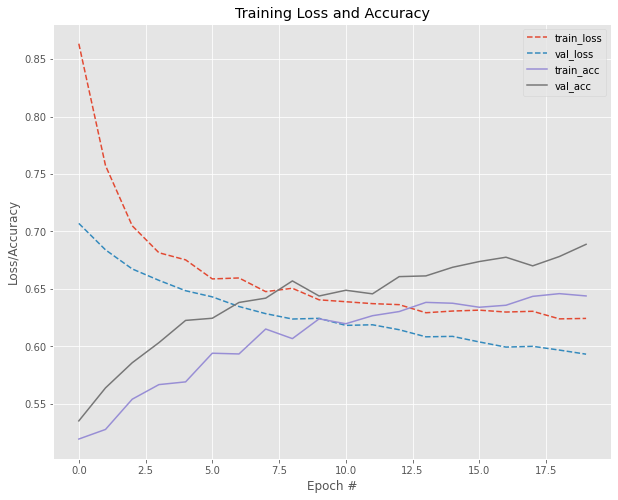

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.03378533305638425 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0015509621830682606 kWh
[INFO] Energy consumed for all GPU: 0.018362935258889056 kWh
[INFO] Energy consumed for all CPU: 0.013871435614426933 kWh
[INFO] CO2 emission 0.007383259298252665(in Kg)


In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model_resNet50.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
12/12 [==============================] - 2s 99ms/step
              precision    recall  f1-score   support

        Fire       0.70      0.84      0.76       183
    Non-Fire       0.82      0.68      0.74       201

    accuracy                           0.75       384
   macro avg       0.76      0.76      0.75       384
weighted avg       0.76      0.75      0.75       384



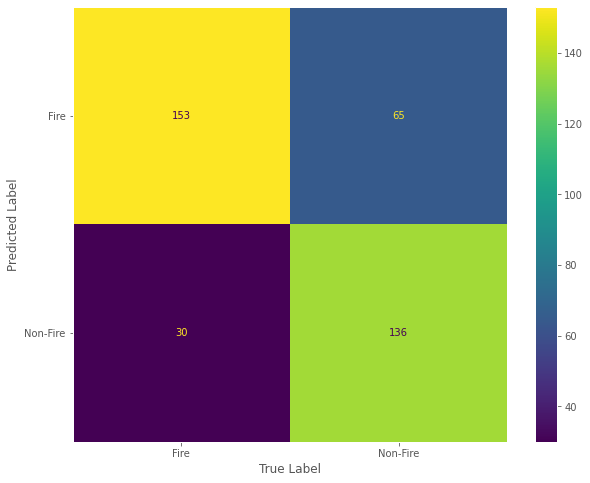

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                    tf.argmax(labels, axis=1)),
                  display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

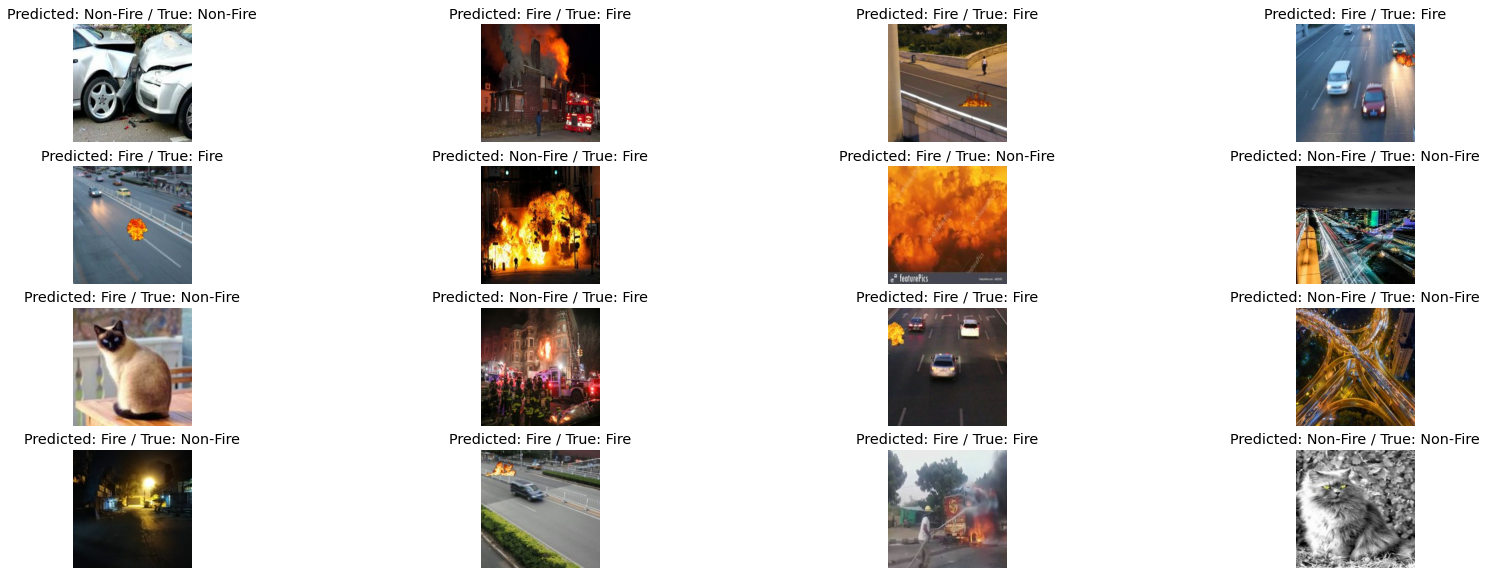

In [ ]:
plt.figure(figsize=(28,10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  true = tf.argmax(labels, axis=1).numpy().astype('uint8')[i]
  pred = tf.argmax(predictions, axis=1).numpy().astype('uint8')[i]
  plt.imshow(images[i].astype('uint8'))
  plt.title("Predicted: {} / True: {}".format(class_names[pred], class_names[true]))
  plt.axis("off")

In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')

precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')

recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')

acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

run.summary["Count_Params"] = model_resNet50.count_params()

run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy

run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

30-11-2022 03:07:24 Validation Evaluation metrics
30-11-2022 03:07:24 Validation Accuracy: 0.7526041666666666
30-11-2022 03:07:24 Validation Precision: 0.7633085380512877
30-11-2022 03:07:24 Validation Recall: 0.7526041666666666
30-11-2022 03:07:24 Validation F1: 0.7516039388925506


In [ ]:
run.finish()

Acc,0.7526
CO2_Emissions,0.00738
Count_Params,23591810
Energy_CPU,0.01387
Energy_Consumed,0.03379
Energy_GPU,0.01836
Energy_RAM,0.00155
F1,0.7516
Precision,0.76331
Recall,0.7526


# Fine-Tuning the Model


## Indexes and layers

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50

# whether or not to include top of CNN
include_top = 0

# load the Mobile network
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalizat

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

### First Stage

In [ ]:
args = {
  "project_name": "fire_detection_classifier"
}

In [ ]:
run = wandb.init(entity="euripedes", project=args["project_name"], job_type="Train")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model 
# this will become the actual model we will train
ft_resNet50_model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
ft_resNet50_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                           

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(ft_resNet50_model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in ft_resNet50_model.layers[4].layers:
	layer.trainable = False

In [ ]:
ft_resNet50_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                           

In [ ]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)

ft_resNet50_model.compile(loss="categorical_crossentropy", 
                       optimizer=opt,
                       metrics=["accuracy"])

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
tracker_1 = EmissionsTracker(log_level="critical")
tracker_1.start()

print("[INFO] training head...")
history = ft_resNet50_model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

emissions = tracker_1.stop()

[INFO] training head...
Epoch 1/3
251/251 [==============================] - 49s 174ms/step - loss: 0.5569 - accuracy: 0.9096 - val_loss: 0.0946 - val_accuracy: 0.9769
Epoch 2/3
251/251 [==============================] - 45s 174ms/step - loss: 0.2023 - accuracy: 0.9565 - val_loss: 0.1368 - val_accuracy: 0.9663
Epoch 3/3
251/251 [==============================] - 45s 175ms/step - loss: 0.2090 - accuracy: 0.9601 - val_loss: 0.0938 - val_accuracy: 0.9800


### Second Stage

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(ft_resNet50_model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(ft_resNet50_model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalization
[INFO] 44	Activation
[INFO] 45	Conv2D
[INFO] 46

In [ ]:
ft_resNet50_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                           

In [ ]:
# loop over the layers in the base model network that where selected 
# and display them to the console
for (i, layer) in enumerate(ft_resNet50_model.layers[4].layers[155:]):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	Conv2D
[INFO] 1	BatchNormalization
[INFO] 2	Activation
[INFO] 3	Conv2D
[INFO] 4	BatchNormalization
[INFO] 5	Activation
[INFO] 6	Conv2D
[INFO] 7	BatchNormalization
[INFO] 8	Add
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	BatchNormalization
[INFO] 15	Activation
[INFO] 16	Conv2D
[INFO] 17	BatchNormalization
[INFO] 18	Add
[INFO] 19	Activation


In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in ft_resNet50_model.layers[4].layers[155:]:
	layer.trainable = True

In [ ]:
ft_resNet50_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                           

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
ft_resNet50_model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [ ]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
tracker_2 = EmissionsTracker(log_level="critical")
tracker_2.start()

print("[INFO] training head...")
history = ft_resNet50_model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

emissions = tracker_2.stop()

[INFO] training head...
Epoch 1/10
251/251 [==============================] - 54s 189ms/step - loss: 0.0924 - accuracy: 0.9721 - val_loss: 0.0586 - val_accuracy: 0.9856
Epoch 2/10
251/251 [==============================] - 49s 188ms/step - loss: 0.0769 - accuracy: 0.9768 - val_loss: 0.0582 - val_accuracy: 0.9875
Epoch 3/10
251/251 [==============================] - 49s 191ms/step - loss: 0.0731 - accuracy: 0.9790 - val_loss: 0.0658 - val_accuracy: 0.9850
Epoch 4/10
251/251 [==============================] - 49s 190ms/step - loss: 0.0687 - accuracy: 0.9792 - val_loss: 0.0406 - val_accuracy: 0.9887
Epoch 5/10
251/251 [==============================] - 49s 190ms/step - loss: 0.0682 - accuracy: 0.9780 - val_loss: 0.0619 - val_accuracy: 0.9825
Epoch 6/10
251/251 [==============================] - 49s 189ms/step - loss: 0.0642 - accuracy: 0.9802 - val_loss: 0.0577 - val_accuracy: 0.9850
Epoch 7/10
251/251 [==============================] - 48s 185ms/step - loss: 0.0582 - accuracy: 0.9817 - v

## Evaluation metrics

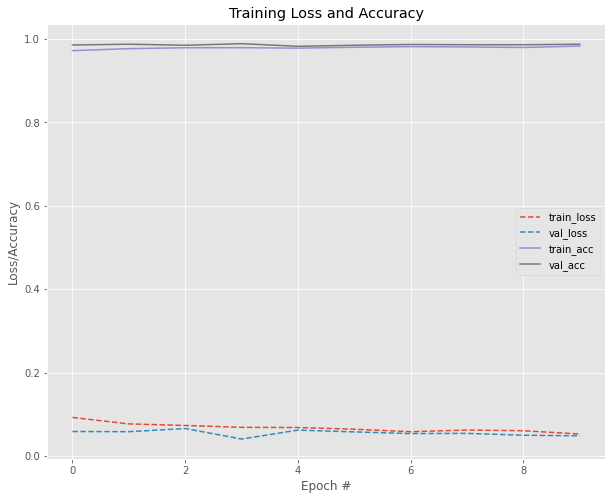

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker_1.final_emissions_data.energy_consumed + 
                                                                    tracker_2.final_emissions_data.energy_consumed))

print("[INFO] Energy consumed for RAM: {} kWh".format(tracker_1.final_emissions_data.ram_energy + 
                                                      tracker_2.final_emissions_data.ram_energy))

print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker_1.final_emissions_data.gpu_energy
                                                          + tracker_2.final_emissions_data.gpu_energy))

print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker_1.final_emissions_data.cpu_energy + 
                                                          tracker_2.final_emissions_data.cpu_energy))

print("[INFO] CO2 emission {}(in Kg)".format(tracker_1.final_emissions_data.emissions 
                                             + tracker_2.final_emissions_data.emissions))

[INFO] 0.028325589176414374 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.001280561609479753 kWh
[INFO] Energy consumed for all GPU: 0.015592034674338163 kWh
[INFO] Energy consumed for all CPU: 0.011452992892596457 kWh
[INFO] CO2 emission 0.0061901171527959(in Kg)


In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = ft_resNet50_model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
12/12 [==============================] - 2s 96ms/step
              precision    recall  f1-score   support

        Fire       0.99      0.98      0.98       196
    Non-Fire       0.98      0.99      0.98       188

    accuracy                           0.98       384
   macro avg       0.98      0.98      0.98       384
weighted avg       0.98      0.98      0.98       384



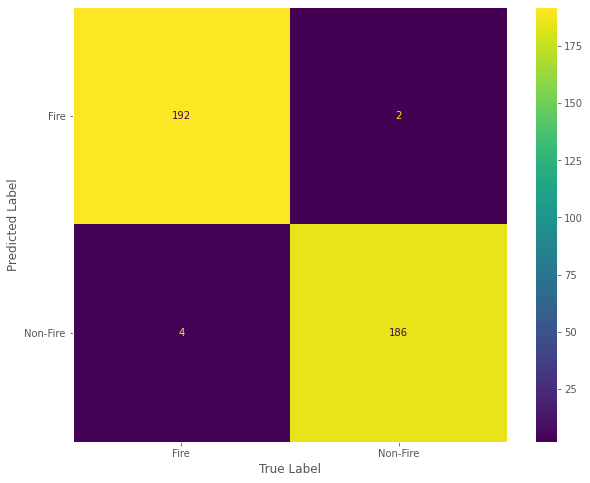

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')

precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')

recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')

acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

run.summary["Count_Params"] = ft_resNet50_model.count_params()

run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy

run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

30-11-2022 03:28:48 Validation Evaluation metrics
30-11-2022 03:28:48 Validation Accuracy: 0.984375
30-11-2022 03:28:48 Validation Precision: 0.9844309549647314
30-11-2022 03:28:48 Validation Recall: 0.984375
30-11-2022 03:28:48 Validation F1: 0.9843762718762719


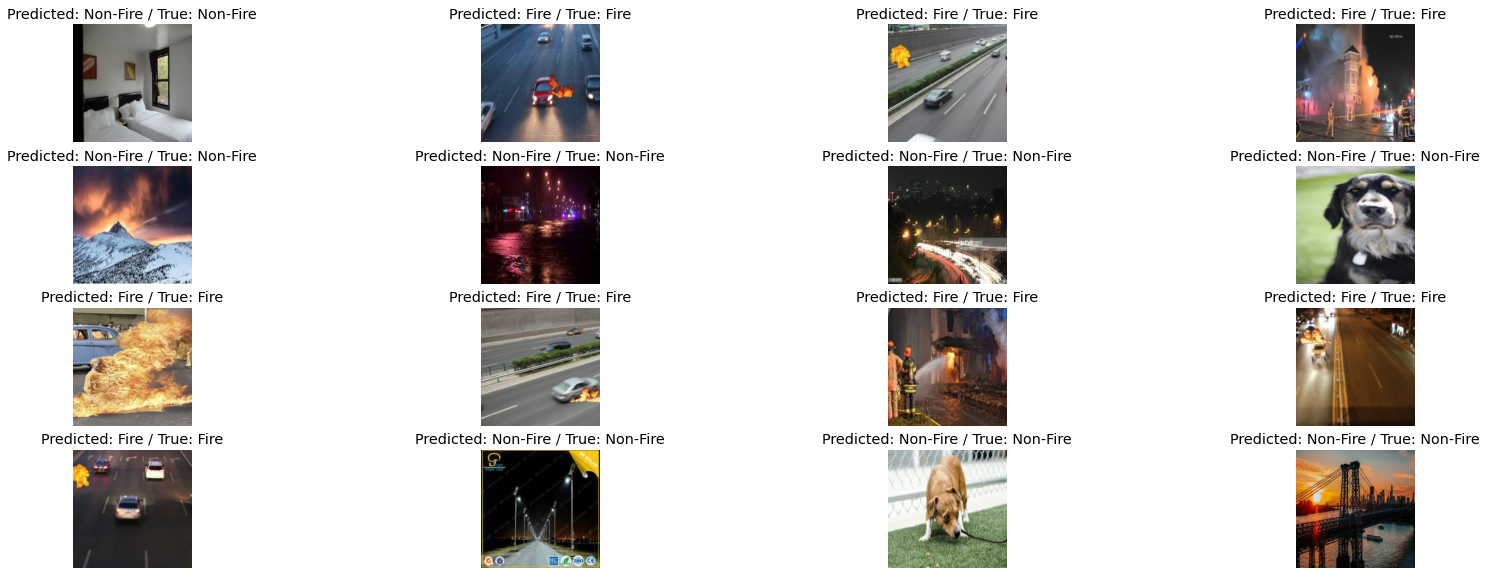

In [ ]:
plt.figure(figsize=(28,10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  true = tf.argmax(labels, axis=1).numpy().astype('uint8')[i]
  pred = tf.argmax(predictions, axis=1).numpy().astype('uint8')[i]
  plt.imshow(images[i].astype('uint8'))
  plt.title("Predicted: {} / True: {}".format(class_names[pred], class_names[true]))
  plt.axis("off")

In [ ]:
run.finish()

Acc,0.98438
CO2_Emissions,0.00738
Count_Params,49278594
Energy_CPU,0.01387
Energy_Consumed,0.03379
Energy_GPU,0.01836
Energy_RAM,0.00155
F1,0.98438
Precision,0.98443
Recall,0.98438
